In [14]:
using Distributions
using LinearAlgebra
using Plots
using LaTeXStrings

In [15]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

generate_initial_guesses (generic function with 1 method)

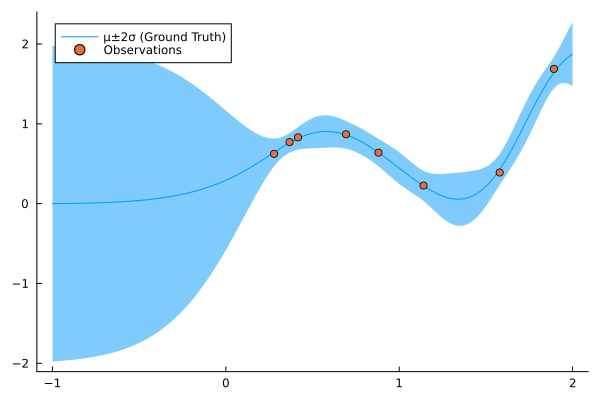

In [95]:
MC_SAMPLES = 1
NUMBER_OF_STARTS = 8
NUMBER_OF_TRIALS = 1
HORIZON = 1
BATCH_SIZE = 8
USE_LDS = true
INITIAL_SAMPLES = 8

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-2
ψ = kernel_matern52(θ)
testfn = TestLinearCosine1D(1., 6.2)
testfn = TestFunction(
    1, [-1. 2.], (zeros(1),),
    x -> sin(3first(x)) + first(x)^2 - .7first(x),
    x -> [0.]
)
lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]

# Generate low discrepancy sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_samples[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    USE_LDS ? lds_rns : rns,
    lbs,
    ubs,
)

# Initialize batch of points to evaluate the rollout acquisition function
batch = generate_batch(BATCH_SIZE, lbs=tp.lbs, ubs=tp.ubs)

# Initialize shared memory for solving base policy in parallel
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

trial = first(rand(1:NUMBER_OF_TRIALS, 1))
Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
# Xinit = [.5;; .47;; 1.2;; -.2;; -.85;; 1.6;; 1.7;; 1.78;; 1.81;; 1.89;;]
yinit = testfn.f.(eachcol(Xinit))
# sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2);
sur = optimize_hypers_optim(
    fit_surrogate(ψ, Xinit, yinit; σn2=σn2),
    kernel_matern52
);
plot1D(sur, xmin=first(lbs), xmax=first(ubs))

## The Knowledge Gradient Acquisition Function

In [96]:
function get_minimum(s::Union{RBFsurrogate, FantasyRBFsurrogate}, lbs, ubs; guesses)
    function predictive_mean(x)
        return s(x).μ
    end

    function grad_predictive_mean!(g, x)
        g[:] = s(x).∇μ
    end

    final_minimizer = (initial_guesses[:, 1], Inf)
    for j in 1:size(guesses, 2)
        guess = guesses[:, j]
        result = optimize(
            predictive_mean, grad_predictive_mean!,
            lbs, ubs, guess, Fminbox(LBFGS()), Optim.Options(x_tol=1e-3, f_tol=1e-3)
        )
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end

    return final_minimizer
end

function distributed_get_minimum(s::Union{RBFsurrogate, FantasyRBFsurrogate}, lbs, ubs; guesses)
    function predictive_mean(x)
        return s(x).μ
    end

    function grad_predictive_mean!(g, x)
        g[:] = s(x).∇μ
    end

    
    candidate_locations = SharedMatrix{Float64}(1, size(guesses, 2))
    candidate_values = SharedArray{Float64}(size(guesses, 2))
    
    @sync @distributed for j in 1:size(guesses, 2)
        guess = guesses[:, j]
        result = optimize(
            predictive_mean, grad_predictive_mean!,
            lbs, ubs, guess, Fminbox(LBFGS()), Optim.Options(x_tol=1e-3, f_tol=1e-3)
        )
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)
        candidate_locations[:, j] = cur_minimizer
        candidate_values[j] = cur_minimum
    end

    mini, j_mini = findmin(candidate_values)
    minimizer = candidate_locations[:, j_mini]

    return minimizer
end


function knowledge_gradient_constructor(s::RBFsurrogate, lbs, ubs; guesses, M)
    stdnormals = randn(length(lbs) + 1, M)
    pair = get_minimum(s, lbs, ubs, guesses=guesses)
    xmini = pair[1]
    μ0 = pair[2]
    ∇μ0 = s(xmini).∇μ
    
    function knowledge_gradient(x)
        μnext = zeros(M)
        fsur = fit_fsurrogate(s, 0)

        for i in 1:M
            # Update surrogate and compute new minimum for predictive mean
            # fsur = fit_fsurrogate(s, 0)
            update_fsurrogate!(fsur, x, gp_draw(s, x, stdnormal=stdnormals[1, i]))
            μnext[i] = get_minimum(fsur, lbs, ubs, guesses=guesses)[2]
            reset_fsurrogate!(fsur, s)
        end

        return -sum(μ0 .- μnext) / M
    end

    return knowledge_gradient
end


function knowledge_gradient_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, M=100)
    μmin = get_minimum(s, lbs, ubs, guesses=initial_guesses)
    kgx = knowledge_gradient_constructor(s, lbs, ubs, guesses=initial_guesses, M=M)

    final_minimizer = (initial_guesses[:, 1], Inf)
    for j in 1:size(initial_guesses, 2)
        print("|")
        guess = initial_guesses[:, j]
        result = optimize(
            kgx,
            lbs, ubs, guess, Fminbox(LBFGS()), Optim.Options(x_tol=1e-3, f_tol=1e-3)
        )
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end

    return final_minimizer
end


knowledge_gradient_solver (generic function with 1 method)

In [97]:
kg = knowledge_gradient_constructor(sur, lbs, ubs, guesses=initial_guesses, M=25);
# fd_dkg(x) = centered_fd(kg, [x], [1.], 1e-6)
domain = first(lbs):.01:first(ubs)
kgx = [kg([x]) for x in domain];

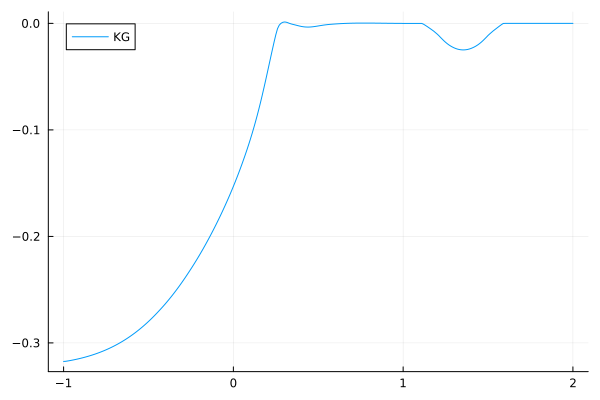

In [98]:
plot(domain, kgx, label="KG")

In [52]:
@time kg_solve = knowledge_gradient_solver(sur, lbs, ubs, initial_guesses=initial_guesses, M=25)

||||||||||100.755095 seconds (2.89 G allocations: 155.701 GiB, 10.37% gc time, 0.07% compilation time)


([-0.9997453150143161], -0.23500086116844363)

In [99]:
kg = knowledge_gradient_constructor(sur, lbs, ubs, guesses=initial_guesses, M=1);
# @time kgx = [kg([x]) for x in domain];

In [101]:
@time kg([0.])

  0.001647 seconds (37.70 k allocations: 2.086 MiB)


0.0545458057245002

In [103]:
@time simulate_trajectory(sur, tp, initial_guesses, variance_reduction=false,
    candidate_locations=candidate_locations, candidate_values=candidate_values
)

  0.006966 seconds (51.20 k allocations: 2.829 MiB)


(0.25459496149815247, [0.0], NaN, NaN)

In [104]:
@time μmin = get_minimum(sur, lbs, ubs, guesses=initial_guesses)

  0.006332 seconds (50.21 k allocations: 3.102 MiB, 56.96% compilation time)


([-0.9999999999776127], 0.00011908689920325788)

In [107]:
x = [0.]
stdnormal = randn()


@time fsur = fit_fsurrogate(sur, 0)
@time update_fsurrogate!(fsur, x, gp_draw(sur, x, stdnormal=stdnormal))
@time get_minimum(fsur, lbs, ubs, guesses=initial_guesses)[2]
@time reset_fsurrogate!(fsur, sur)

  0.000016 seconds (10 allocations: 2.594 KiB)
  0.000177 seconds (156 allocations: 9.953 KiB)
  0.001411 seconds (31.77 k allocations: 1.756 MiB)
  0.000008 seconds


In [108]:
@time distributed_get_minimum(fsur, lbs, ubs, guesses=initial_guesses[:, 1])

  0.000959 seconds (7.91 k allocations: 454.406 KiB)


1-element Vector{Float64}:
 -0.9999999999745529

8